<a href="https://colab.research.google.com/github/dzeke/ColoradoRiverCollaborate/blob/main/Powell10year.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Colorado River reservoir data from Reclamation's Web Service
## David E. Rosenberg
## May 23, 2024

## Overview
This is a Jupyter Notebook (.ipynb). This document reads daily Reclamation data for Colorado River reservoirs from U.S. Bureau of Reclamation's (Reclamation) web portal https://www.usbr.gov/uc/water/hydrodata/reservoir_data/919/csv/25.csv). Here, as an example, *919* is the code for Lake Powell. And *25* is the code for reservoir evaporation.

First the code creates a class object for reservoirs and their data. This class has several properties
    + Initialization
        - Read in the meta data file
        - Create the data objects for the table of metadata, cross-tabulated table of metadata (reservoirs, code, data field1, data field2, etc)
        - Table of daily data for reservoirs and each field
        - Table of selected reservoir and field aggregated to specified level
    + Methods
        - Get list of fields for specified reservoir
        - Get reservoir and 1 field of data aggregated to specified time step
        - Plot reservoir and 1 field
        

reads in the Metadata for all available reservoirs and data fields from the file 'https://raw.githubusercontent.com/dzeke/ColoradoRiverCollaborate/main/Powell10year/AsPython/ReclamationMetaData.csv.' This metadata includes reservoir name, site id, field name, field ids, units of measurement, and so forth.

Second, the code then iterates over all specified reservoirs and reads in the associated data fields.

Third, the code combines data for all the fields into a database (Pandas dataframe). The database has the columns:
    Date_Raw, Value, Reservoir_ID, Reservoir_Name, Field_ID, Field_Name, Units.
    
Fourth, the code then aggregates data to yearly (water year starting Oct 1).

Fifth, the code plots data for different reservoirs and fields. For example:

 + Evaporation
 + Total evaporation for each period of consecutative 10 years

## Directions to Open, Edit, and Run (Windows)
1. Download all the files into a new local folder on your machine or storage device (e.g., c:\users\myfolder).
2. Open a command prompt (c:\).
3. Install the Juptyer server. At the command prompt type:
    >> pip install jupyter
4. Navigate to the folder where this file is stored. For example:
    >> cd C:\users\myfolder
5. Type the command:
    >> jupyter notebook
6. A new webpage will open in your browser with the url *http://localhost:8888/tree.*
7. Select this file from the list -- **USBRDataImport.ipynb**.
8. This page will display.
9. Select the first cell -- e.g., block [19] to run or edit. You should see the follow output:
    >> A list of numbers from 912 to 923. The reservoir codes.
    >> A list of reservoir names and numbers to the right. e.g.
            Blue Mesa Reservoir 16.
                Here, 16 indicates the number of data fields for the reservoir. e.g, Inflow, Storage, Evaporation, etc.
11. Run each successive cell.

## Requested Citation
David E. Rosenberg (2024), “Import Reservoir Data from Reclamation.” Utah State University. Logan, Utah.
https://github.com/dzeke/ColoradoRiverCollaborate/tree/main/Powell10year/AsPython.

### Pandas Cheat Sheet
Pandas cheat sheet at https://pandas.pydata.org/docs/user_guide/10min.html.

In [25]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype

# Add this command on first run of cell
#!pip install plotnine
from plotnine import *
from plotnine.data import mpg
%matplotlib inline

# Show all records for a pandas data frame
pd.set_option('display.max_rows', None)

### Create the class object USBR reservoir data from api

class usbrdatafromapi:
    # Define a constructor. Read the meta data file and load it's contents into the variable MetaDataFile and Data frame that contains the MetaDataFile
    # records
    def __init__(self, metadatafile):
        # Read in the meta data file and store in the dataframes dfMeta and dfMetaWork
        self.metadatafile = metadatafile

        try:
            self.dfMeta = self.dfMetaWork = pd.read_csv(self.metadatafile)
        except:
           #Default, csv file in github repository
           print(f'Metadatafile {self.metadatafile} does not exist. Using default') 
           self.metadatafile = 'https://raw.githubusercontent.com/dzeke/ColoradoRiverCollaborate/main/Powell10year/AsPython/ReclamationMetaData.csv'
           self.dfMeta = self.dfMetaWork = pd.read_csv(self.metadatafile)

        # Set aggregate data options
        self.AggregateOptions = AggregateOptions = ['Day', 'Month', 'Year', 'TenYear']
        self.ResID = None
        self.FieldID = None
    
    # Define methods to set and get the values of the metadatafile, dfMeta data frame, and working version of the dfMeta data frame
    def set_dfMetaWork(self, lResCodes):
        # lResCodes is a subset of list of reservoir codes in the dfMeta data frame
        #This method filters the dfMeta data frame on the provided lResCodes.
        #The method also reduces the columns to the selected ones
        #The method returns the records in the data frame dfMetaWork
    
        self.lResCodes = lResCodes #Filter on the reservoirs in lResCodes - https://www.kdnuggets.com/2022/12/five-ways-conditional-filtering-pandas.html
        
        try:
            self.dfMetaWork = self.dfMeta.query('site_id.isin(@self.lResCodes)')
        except:
            #Default - use all reservoir codes
            print(f'List of reservoir codes does not exist. Defaulting to all reservoirs')
            self.dfMetaWork = self.dfMeta
        
        self.dfMetaWork = self.dfMetaWork.reset_index()

        return self.dfMetaWork
    
    def get_ReservoirAndFields(self, bPrint):
        #This method show reservoirs and fields from the dfMetaWork data frame
        #The parameter bPrint is a boolian - print if true
        #Count number of fields per reservoir and also show the reservoir ID
        self.dfReservoirFields = pd.DataFrame(self.dfMetaWork.groupby(['site_metadata.site_name', 'site_id']).size().reset_index())

        #Change the third column to be Number of Fields
        self.dfReservoirFields.columns = ['Reservoir', 'Site_ID', 'Number of Fields']
        print(self.dfReservoirFields)
        
        ### Reshape the reservoir fields table so fields are now columns and can
        #   see which reservoirs have which fields
        # Reshape the DataFrame from long to wide format
        # Create a new column that specifies the Reservoir name and ID as one
        self.dfMetaWork['ResNameCode'] = self.dfMetaWork['site_metadata.site_common_name'] + ' [' + self.dfMetaWork['site_id'].astype(str) + ']'
        #Create a new column that specifies the field name and code
        self.dfMetaWork['FieldNameCode'] = self.dfMetaWork['datatype_metadata.datatype_common_name'] + ' [' + self.dfMetaWork['datatype_id'].astype(str) + ']'
        #Reshape
        self.df_ResFieldsWide = self.dfMetaWork.pivot_table(index='ResNameCode', columns='FieldNameCode', values='datatype_id', aggfunc='sum')
      
        #Print out information about the data in dfMetawork
        if bPrint:
            print(f'Number of Columns of dfMetaData: {len(self.dfMetaWork.columns)}')
            print(f'Number of Rows of dfMetaData: {len(self.dfMetaWork)}')
            print()
            print(self.dfMetaWork)
            print()
            print(self.df_ResFieldsWide)
        
        #Save the wide version to csv for easier viewing no matter what
        self.df_ResFieldsWide.to_csv('ReservoirsAndFields.csv')
    
    def get_dfResField(self, ResID, FieldID, bPrint):
        # This method loads data from the reservoir ResID and field FieldID in dfMetaWork
        # We load the data from Reclamation's webservice
        # We store the data in the dfResField data frame
        # bPrint is a boolean - True will print stuff
        # Get the column names
        
        self.ResID = ResID
        self.FieldID = FieldID
        
        lResColumnNames = self.dfMetaWork.columns
        #Subset the list of column names to those we want
        lResColumnsUse = list(lResColumnNames[i] for i in [2, 3, 5, 6, 11, 27, 28, 29, 30, 31, 32, 33] )

        #Create a new empty data frame. Rename Reclamation field names to more useful headers."
        lColumnsNewName = ['Date_Raw', 'Value', 'Reservoir_ID', 'Field_ID', 'Reservoir_Name', 'Reservoir_CommonName',  'Basin', 'Field_Name', 'Field_CommonName', 'Balance_Component', 'Unit_ID', 'Unit_Name', 'Unit_CommonName', 'Interval']
    
        self.dfResField = pd.DataFrame(columns = lColumnsNewName)

        if bPrint:
            print(type(self.dfMetaWork))
            print(pd.DataFrame(lResColumnNames, columns = ['RawName']))

        # Creat a data frame with raw and new columns to check correspondence
        dfColumnsCheck = pd.DataFrame(list(zip(lColumnsNewName[2:], lResColumnsUse)),
                                   columns = ['NewName', 'RawName'])
        #print(f'dfColumnsCheck: {dfColumnsCheck}')

        if bPrint:
            print()
            print(self.dfResField)

        # Set the url for the Reclamation servier with the data. Example for evaporation from Lake Powell
        sEvapDataAsUrl = 'https://www.usbr.gov/uc/water/hydrodata/reservoir_data/919/csv/25.csv'

        # Find the correct row in dfMetaWork for the ResID and FieldID
        dfCurrMetaRow = self.dfMetaWork.query('site_id.isin(@ResID) and datatype_id.isin(@FieldID)').reset_index()

        #Loop over the records in the dfReservoirData dataframe - https://www.geeksforgeeks.org/different-ways-to-iterate-over-rows-in-pandas-dataframe/
        for i in range(0,1):
        #for i in range(len(dfReservoirData)):  

            try:
                sResID = str(dfCurrMetaRow.loc[i, 'site_id'])
            except KeyError:
                print("Couldn't find a match for the Reservoir ID: ", i)

            sFieldID = str(dfCurrMetaRow.loc[i, 'datatype_id'])

            sURL = 'https://www.usbr.gov/uc/water/hydrodata/reservoir_data/' + sResID + '/csv/' + sFieldID + '.csv' 

            # Retrieve and move the dataset for the current reservoir and field into a Pandas Dataframe
            try:
                dfCurr = pd.read_csv(sURL)
                print(f'Loaded: {sURL}')
            except:
                print(f'  Failed to load: {sURL}')
                continue

            # Change the column names of the first two columns to Date_Raw, Value
            dfCurr.columns = [lColumnsNewName[0], lColumnsNewName[1]]

            #Loop over the remaining columns, transfer meta data from dfMetaWork to current dataframe
            #for j in range(2,4):
            for j in range(2,len(lColumnsNewName)):
                #print(f'{j} - {lColumnsNewName[j]} - {lResColumnsUse[j-2]}')
                #dfReservoirData.get(lResColumnsUse[j-2])
                dfCurr[lColumnsNewName[j]] = dfCurrMetaRow.loc[i, lResColumnsUse[j-2]]
    
            #print(dfCurr.head())

            # Append the current data to the big data frame\n",
            self.dfResField = dfCurr
            
           # if i == 0:
           #     self.dfAllData = dfCurr
           # else:
           #     frames = [self.dfAllData, dfCurr]
           #     self.dfAllData = pd.concat(frames, ignore_index=True)

        if bPrint:
            print(self.dfResField.dtypes)
            print(self.dfResField.head())
        
        return self.dfResField

    def clean_dfResField(self, bPrint):
        # This method cleans the dfResField data frame
        # Convert raw date to formal date
        self.dfResField['date'] = pd.to_datetime(self.dfResField['Date_Raw'])

        #Add year and month columns
        self.dfResField['year'] = pd.DatetimeIndex(self.dfResField['date']).year
        self.dfResField['month'] = pd.DatetimeIndex(self.dfResField['date']).month
        self.dfResField['day'] = pd.DatetimeIndex(self.dfResField['date']).day

        #Calculate the water year, Increment by 1 year, Months 10, 11, 12
        self.dfResField['wateryear'] = self.dfResField['year']
        self.dfResField.loc[self.dfResField['month'] >= 10, 'wateryear'] = self.dfResField['year'] + 1

        nRows = len(self.dfResField)

        if bPrint:
            print(self.dfResField.dtypes)
            print(self.dfResField.head())
            print(f'Number of rows read: {nRows}')    

        #Turn the unique reservoir IDs and names into a dataframe to show IDs and Names
        dataRes = {'ReservoirID': self.dfResField.Reservoir_ID.unique(),
                    'Reservoir': self.dfResField.Reservoir_CommonName.unique()}
        dfReservoirs = pd.DataFrame(dataRes)

        if bPrint:
            print(dfReservoirs)        

        #Turn the unique Field IDs and names into a dataframe to show lookup by number
        dataFields = {'FieldID': self.dfResField.Field_ID.unique(),
                  'Field': self.dfResField.Field_CommonName.unique()}
        self.dfFields = pd.DataFrame(dataFields)
        
        if bPrint:
            print(self.dfFields)

        # https://www.geeksforgeeks.org/get-unique-values-from-a-column-in-pandas-dataframe/
        return self.dfResField
    
    def get_aggregateResField(self, Aggregate, bPrint):
        ## This method aggregates the dfResField to the specified timestep Aggregate

        # Read the field from the dfResField data frame
        #resID = [919]
        #fieldID = [25] # Evaporation
        #fieldID = [30]  # Inflow volume
        #fieldID = [17]  # Storage
        #fieldID = [43] # Release volume

        #fieldID = 

        # Options to aggregate by time period
        # Aggregate daily data to time interval
        # Select the aggregate option to use
        #Aggregate = AggregateOptions[3]

        #Convert fieldID as list to integer
        nfieldID = int(''.join(map(str, self.FieldID)))
        print(nfieldID)

        #Field IDs where aggregate at monthly, annual and 10-year we want the value at the last time period
        lFieldIDsEndofPeriod = [17, 49, 89]
        dfFieldsEoP = self.dfFields.query('FieldID.isin(@lFieldIDsEndofPeriod)').reset_index()

        print('These fields we take the end of period value not the sum')
        print(dfFieldsEoP.head())

        print(f'nfieldID in lFieldIDsEndofPeriod: {nfieldID in lFieldIDsEndofPeriod}')

        #Query on the resID and fieldID
        #sedfResField = dfAllData.query('Reservoir_ID.isin(@resID) and Field_ID.isin(@fieldID)').reset_index()

        ### Further Process the field based on the aggregate option
        self.sField = str(self.dfResField.Field_CommonName[0])
        #sField = sField.capitalize
        print(self.sField)

        if Aggregate == self.AggregateOptions[0]:
            # Daily, return same data frame
            print('Daily value - no aggregation')
            self.dfResFieldAgg = self.dfResField
    
        elif Aggregate == self.AggregateOptions[1]:
            # Daily to Monthly
            # Trim months with less than 28 days
            # Calculate number of days/records for each water year
            dfDaysPerMonth = pd.DataFrame(self.dfResField.groupby(['Reservoir_ID', 'Field_ID', 'Field_CommonName', 'Unit_ID', 'Unit_CommonName', 'Interval', 'wateryear', 'month']).size().reset_index())
            # Rename the column name 0 to DaysPerYear
            dfDaysPerMonth.columns = ['Reservoir_ID', 'Field_ID', 'Field_CommonName', 'Unit_ID', 'Unit_CommonName', 'Interval', 'wateryear', 'month', 'DaysPerMonth']
            # Filter to years with more than 360 days / records
            dfFullMonths = dfDaysPerMonth.query('DaysPerMonth >= 28')

            # Check the full years
            #print(dfDaysPerWaterYear.head)
            #print(dfFullYears.head())
   
            if nfieldID in lFieldIDsEndofPeriod:
                # This field is end-of-period value
                # Take the monthly value as the value on the first day in the month
                print('Monthly end of period value')
                dfWaterYearMonth = self.dfResField.query('day == 1')

            else:
                # This field is sum over period
                # Aggregate to monthly values
                print('Monthly sum over field')
                dfWaterYearMonth = self.dfResField.groupby(['Reservoir_ID', 'Field_ID', 'Field_CommonName', 'Unit_ID', 'Unit_CommonName', 'Interval', 'wateryear', 'month'])[['Value']].sum().reset_index()    # Pull value for last day in water use for fields with Intervals 'either'

                # Left join to only include Months with more than 27 days
                #dfAllDataWaterYear = dfFullYears.merge(dfAllDataWaterYear, on='wateryear', how='left')
                dfWaterYearMonth = dfFullMonths.merge(dfWaterYearMonth, on=['Reservoir_ID', 'Field_ID', 'Field_CommonName', 'Unit_ID', 'Unit_CommonName', 'Interval', 'wateryear', 'month'], how='left')
                #print(dfWaterYearMonth)

                # Add the datetime field back in
                # Convert year, month, day as integers to single integer, i.e, YYYYMMDD
                dfWaterYearMonth['dateinteger'] = dfWaterYearMonth['wateryear']*10000 + dfWaterYearMonth['month']*100 + 1
                #Convert the dateinteger to a datetime
                dfWaterYearMonth['date'] = pd.to_datetime(dfWaterYearMonth['dateinteger'], format='%Y%m%d')

                self.dfResFieldAgg = dfWaterYearMonth
    
        else: # Annual or 10-year running sum
            ### First aggregate Daily to Annual
    
            # Trim water years with less than 360 days
            # Calculate number of days/records for each water year
            dfDaysPerWaterYear = pd.DataFrame(self.dfResField.groupby(['Reservoir_ID', 'Field_ID', 'Field_CommonName', 'Unit_ID', 'Unit_CommonName', 'Interval', 'wateryear']).size().reset_index())
            # Rename the column name 0 to DaysPerYear
            dfDaysPerWaterYear.columns = ['Reservoir_ID', 'Field_ID', 'Field_CommonName', 'Unit_ID', 'Unit_CommonName', 'Interval', 'wateryear', 'DaysPerYear']
            # Filter to years with more than 360 days / records
            dfFullYears = dfDaysPerWaterYear.query('DaysPerYear >= 360')

            if nfieldID in lFieldIDsEndofPeriod:
                # We have a field that reports value at end of the year
                # Take the value on the first day of the first month of the water year (October 1)
                # 'date' field is preserved
                print()
                print('Annual end of period value')
                dfWaterYear = self.dfResField.query('month == 10 and day == 1')
                #print(dfResField.head())
                #print(dfWaterYear.head())
            else:  
                # Aggregate to annual values
                print()
                print('Annual sum of period value')

                dfWaterYear = self.dfResField.groupby(['Reservoir_ID', 'Field_ID', 'Field_CommonName', 'Unit_ID', 'Unit_CommonName', 'Interval', 'wateryear'])[['Value']].sum().reset_index()    # Pull value for last day in water use for fields with Intervals 'either'
        
                # Left join to only include Water Years with more than 360 days
                dfWaterYear = dfFullYears.merge(dfWaterYear, on=['Reservoir_ID', 'Field_ID', 'Field_CommonName', 'Unit_ID', 'Unit_CommonName', 'Interval', 'wateryear'], how='left')

                # Add the datetime field back in
                # Convert year and October 1 as integers to single integer, i.e, YYYYMMDD
                dfWaterYear['dateinteger'] = dfWaterYear['wateryear']*10000 + 10*100 + 1
                #Convert the dateinteger to a datetime
                dfWaterYear['date'] = pd.to_datetime(dfWaterYear['dateinteger'], format='%Y%m%d')

            self.dfResFieldAgg = dfWaterYear

            if Aggregate == self.AggregateOptions[3]:
                # Calculate a rolling 10-year sum
                df10year = dfWaterYear
                df10year['Value'] = df10year['Value'].rolling(10).sum()

                self.dfResFieldAgg = df10year

                sField = '10-Year ' + sField
    
        # Turn units of acre-feet into million acre-feet if Unit_Name is acre-feet
        if self.dfResFieldAgg['Unit_CommonName'].iloc[0] == 'acre-feet':
            self.dfResFieldAgg.Value = self.dfResFieldAgg.Value / 1e6
            self.dfResFieldAgg.Unit_CommonName = 'million acre-feet'

        # Print out returned dataframe
        print(self.dfResFieldAgg.head())

        return self.dfResFieldAgg   
    
    
    ##Methods to return properties
    def get_metadatafile(self):
        return self.metadatafile

    def get_dfMeta(self):
        return self.dfMeta
        
    def get_dfMetaWork(self):
        return self.dfMetaWork

    def get_lResCodes(self):
        return self.lResCodes

    def get_dfReservoirData(self):
        return self.dfReservoirData     

    # Define methods to get the values of the attributes
    def get_metadatafile(self):
        return self.metadatafile

    def get_lResCodes(self):
        return self.lResCodes

    def get_dfReservoirFields(self):
        return self.dfReservoirFields

#### End of Class
print("Loaded class usbrdatafromapi")

Loaded class usbrdatafromapi


In [26]:
## Load the meta data
inputfile = 'https://raw.githubusercontent.com/dzeke/ColoradoRiverCollaborate/main/Powell10year/AsPython/ReclamationMetaData.csv'
usbrdata = usbrdatafromapi(inputfile)

##Subset the list of reservoirs
#Upper Basin reservoirs
lUpperBasinRes = list(range(912,921,1)) # (1998,1119,1999,3083)
lUpperBasinRes = list(range(919,921,1))
usbrdata.set_dfMetaWork(lUpperBasinRes)
#Display reservoirs, their fields, and codes
usbrdata.get_ReservoirAndFields(False)
usbrdata.get_dfResField([919], [25], False)
usbrdata.clean_dfResField(False)
usbrdata.get_aggregateResField("Month", False)
#print(usbrdata.dfMetaWork)

          Reservoir  Site_ID  Number of Fields
0       LAKE POWELL      919                17
1  NAVAJO RESERVOIR      920                14
Loaded: https://www.usbr.gov/uc/water/hydrodata/reservoir_data/919/csv/25.csv
25
These fields we take the end of period value not the sum
Empty DataFrame
Columns: [index, FieldID, Field]
Index: []
nfieldID in lFieldIDsEndofPeriod: False
evaporation
Monthly sum over field
   Reservoir_ID  Field_ID Field_CommonName  Unit_ID    Unit_CommonName  \
0           919        25      evaporation        1  million acre-feet   
1           919        25      evaporation        1  million acre-feet   
2           919        25      evaporation        1  million acre-feet   
3           919        25      evaporation        1  million acre-feet   
4           919        25      evaporation        1  million acre-feet   

      Interval  wateryear  month  DaysPerMonth  Value  dateinteger       date  
0  non-instant       1963      4            30    0.0     1963

,Reservoir_ID,Field_ID,Field_CommonName,Unit_ID,Unit_CommonName,Interval,wateryear,month,DaysPerMonth,Value,dateinteger,date
0,919,25,evaporation,1,million acre-feet,non-instant,1963,4,30,0.000000,19630401,1963-04-01
1,919,25,evaporation,1,million acre-feet,non-instant,1963,5,31,0.000000,19630501,1963-05-01
2,919,25,evaporation,1,million acre-feet,non-instant,1963,6,30,0.000000,19630601,1963-06-01
3,919,25,evaporation,1,million acre-feet,non-instant,1963,7,31,0.000000,19630701,1963-07-01
4,919,25,evaporation,1,million acre-feet,non-instant,1963,8,31,0.000000,19630801,1963-08-01
5,919,25,evaporation,1,million acre-feet,non-instant,1963,9,30,0.000000,19630901,1963-09-01
6,919,25,evaporation,1,million acre-feet,non-instant,1964,1,31,0.000769,19640101,1964-01-01
7,919,25,evaporation,1,million acre-feet,non-instant,1964,2,29,0.000742,19640201,1964-02-01
8,919,25,evaporation,1,million acre-feet,non-instant,1964,3,31,0.001466,19640301,1964-03-01
9,919,25,evaporation,1,million acre-feet,non-instant,1964,4,30,0.002200,19640401,1964-04-01


# Figure 1. Reservoir Field by Year

NameError: name 'self' is not defined

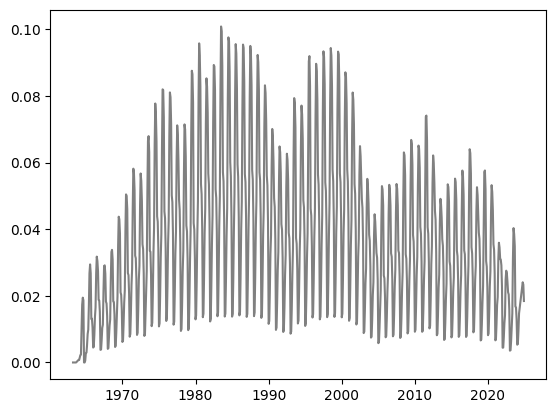

In [24]:
# Use matplotlib

import matplotlib.pyplot as plt

#plt.bar(dfResFieldAgg.wateryear, dfResFieldAgg.Value, color = "grey", width = 1)
# Plot instead using the plot date
plt.plot_date(usbrdata.dfResFieldAgg.date, usbrdata.dfResFieldAgg.Value, 'grey')


plt.xlabel('')
plt.ylabel(self.sField +'\n' + usbrdata.dfResFieldAgg['Unit_CommonName'].iloc[0])
plt.grid(axis = 'y', linestyle = "dotted")

#Use ggplot
###(ggplot(dfEvapWaterYear, aes(x = 'wateryear'))
### + geom_bar(aes(y='evaporation'), color = "grey", fill = "grey", stat="identity")
 # geom_line(aes(y=OneYearRelease, group = 1, color="Release"), size=2) +
#  + scale_color_manual("", values = "grey50")
#  + scale_fill_manual("", values = "grey50")
### + labs(x="", y="Evaporation\n(million acre-feet per year)")

 # + theme(text = element_text(size=20), legend.title=element_blank(), legend.text=element_text(size=18),
#        legend.key = element_blank())
###)


# Next

   wateryear  DaysPerYear  evaporation  Evap10yr
0       1964          366     0.073775       NaN
1       1965          365     0.166053       NaN
2       1966          365     0.216575       NaN
3       1967          365     0.191975       NaN
4       1968          366     0.213552       NaN


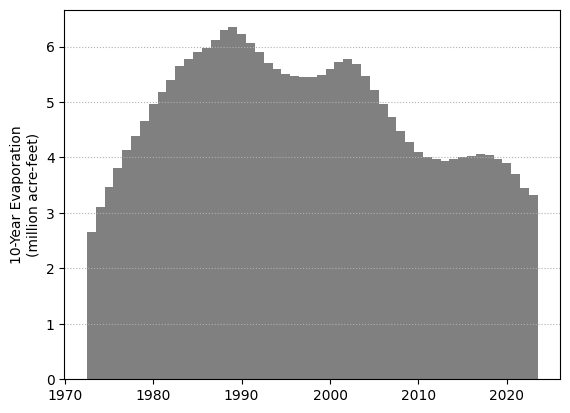